In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
#from torchview import draw_graph
import matplotlib.pyplot as plt
import numpy as np
from auxiliary.visualization import plot_raster

In [2]:
# Metal device enables running the code on the GPU on MacOS (analogous to CUDA)
device = torch.device("mps")

### Loading the data

In [3]:
# Setting up a Dataset object for DataLoader
class BuildingRasterDataset(Dataset):
    def __init__(self, path, transform=None):
        '''Loads and unpacks the data from the compressed .npz format'''
        data = np.load(path)
        
        # Read raster maps
        blocks_rasterized = data["blocks"].copy()
        # Read generalization operators, specified in the following order
        # ["deletion", "aggregation", "typification", "displacement", "enlargement", "simplification"]
        targets_genops = data["genops"].copy()
        # Read target uuids
        self.uuid = data["uuids"].copy()

        # Check whether all parts have the same dimensionality
        assert blocks_rasterized.shape[0] == targets_genops.shape[0] == self.uuid.shape[0]

        # Convert numpy array to tensor with shape (n_samples, 3, height, width)
        self.block = torch.from_numpy(blocks_rasterized)
        self.genops = torch.from_numpy(targets_genops)

        # store transformation
        self.transform = transform

    def __len__(self):
        '''Enables dataset length calculation'''
        return self.uuid.shape[0]

    def __getitem__(self, index):
        '''Enables indexing, returns uuid, target, context and block raster as features and generalization operators as label'''
        uuid = self.uuid[index]
        block = self.block[index]
        genops = self.genops[index]

        if self.transform:
            block = self.transform(block)

        return uuid, block, genops

### Training pipeline

1) Design model (input, output size, forward pass)
2) Construct loss and optimizer
3) Training loop
     * Forward pass: Compute prediction
     * Backward pass: Compute gradients
     * Update weights

### Model design

Stride refers to the number of positions that the convolutional kernel shifts at one step. Input channel size of one layer should always be equal to the output channel size of the previous layer.

The application of convolutions decreases the size of the image: The output after a convolution can be calculated according to the following formula, where $W$ is the input width, $F$ is the kernel size, $P$ is the padding and $S$ is the stride:

$$\frac{(W-F + 2 P)}{S} + 1$$

In [5]:
class CNN(nn.Module):
    # contains the layer architecture
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer taking 1 input channel (image), 16 output channels, kernel size 3
        # grayscale image, 1 input channel, kernel_size = 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # Second convolutional layer, taking 16 input channels, outputting 32 channels, kernel size 3
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Third convolutional layer, taking 32 input channels, outputting 64 channels, kernel size 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # A MaxPooling Layer to reduce the spatial dimensions of the output from convolutional layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer taking the flattened output from the last convolutional layer and outputting 10 classes
        # (for CIFAR-10, for example)
        # The image resulting from the last pooling layer has dimensions (4,4)
        self.fc = nn.Linear(64 * 4 * 4, 10)  # Assuming the input size to the network is 32x32 pixels

    # contains the activation functions
    def forward(self, x):
        # Apply convolutions followed by batch normalization, a ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the output for the fully connected layer, analogously to the init method
        x = x.view(-1, 64 * 4 * 4)
        # no activation function here, as it is included in the loss
        x = self.fc(x)
        return x

# Example of using the model
model = CNN()
print(model)

model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
# criterion =
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Loss and activation function

Softmax is a common activation function, (binary) cross-Entropy is a common loss function for multiclass classification problems, sigmoid is commonly used for binary classification problems. When using the Pytorch implementation: no softmax in the last layer, class labels not one-hot encoded and no softmax. BCELoss requires an activation function at the end! Sigmoid are usually the last layers in binary classification probems.

If you don't know which activation function to use, just use ReLU, Leaky ReLU tries to adress vanishing gradient problem. Multiplies input with small negative numbers, as normal ReLU may cause many gradients to become zero, which means that the weights will never be updated. Whenever weights are not updated during training, use Leaky ReLU.

I am dealing with a multilabel (for each generalization operator), binary (operator present or absent) classification problem.

In [13]:
loss = nn.CrossEntropyLoss()

# correct class label
Y = torch.tensor([2, 0, 1])
# size: n_samples x n_classes --> raw values!
Y_pred_good = torch.tensor([[0.1, 1.0, 2.1], [2.0, 1.0, 0.1], [0.1, 3.0, 0.1]])
Y_pred_bad = torch.tensor([[2.1, 1.0, 0.1], [0.1, 1.0, 2.1], [0.1, 3.0, 0.1]])

l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)

print(l1.item())
print(l2.item())

_, predictions1 = torch.max(Y_pred_good, 1)
_, predictions2 = torch.max(Y_pred_bad, 1)

print(predictions1)
print(predictions2)

0.3018244206905365
1.6241613626480103
tensor([2, 0, 1])
tensor([0, 2, 1])


### Training loop

{60ECECB4-C078-40CC-B2BB-80C4B3BB8E82}
{9B814E34-1B4F-4CC9-B531-B107500218B0}
{81E40A66-FBB2-4AFF-B091-0C8AD461330E}
{2B624E2C-363D-4E2C-886F-E1CFC2DA1304}
{A1BCE3C7-80E6-421F-BB2F-1DB4DFD201D1}
{9B814E34-1B4F-4CC9-B531-B107500218B0}
{D5FEBD98-7D55-4133-8325-7453FA71B05A}
{2B624E2C-363D-4E2C-886F-E1CFC2DA1304}


/Users/jorissenn/Desktop/GEO511 Masterarbeit/Implementation/genops/auxiliary/visualization.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize = (5,5))


{16FA1DDA-3B4C-4F97-89AE-B7A640B5D078}
{0062D315-1B5E-4D9A-8EEE-A8BB71FE90B3}


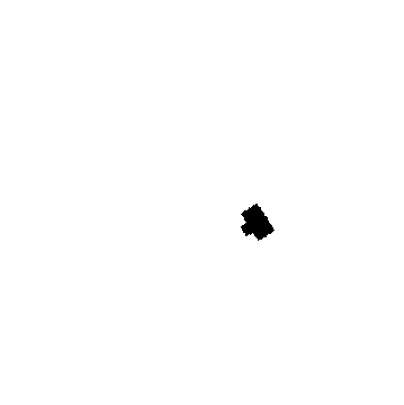

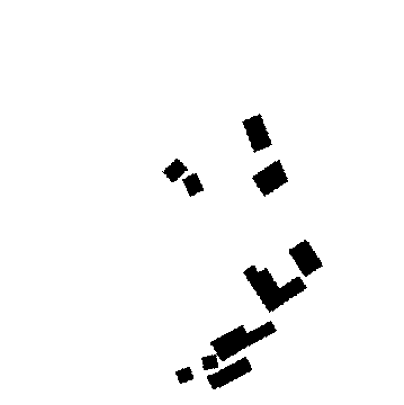

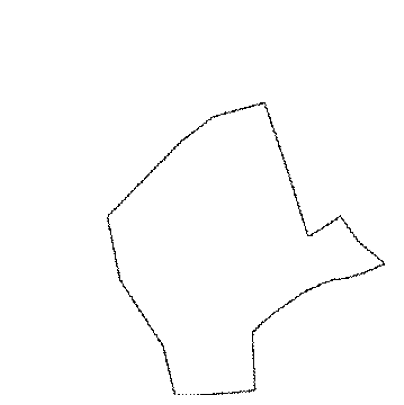

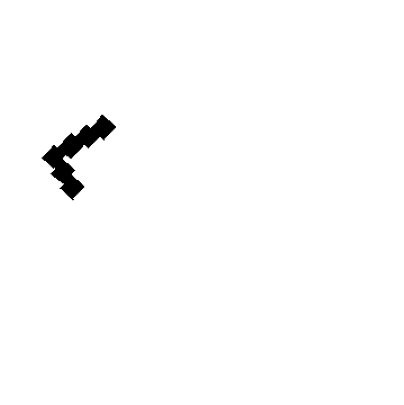

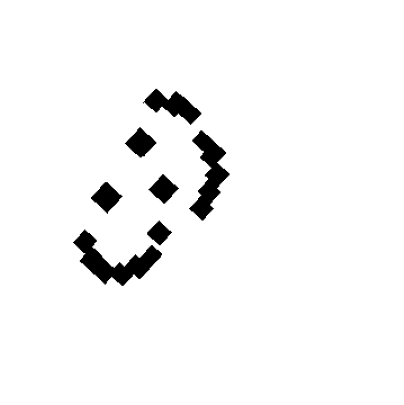

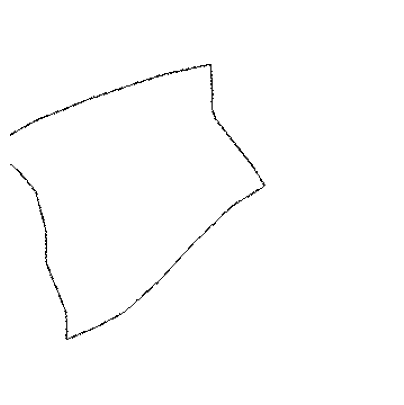

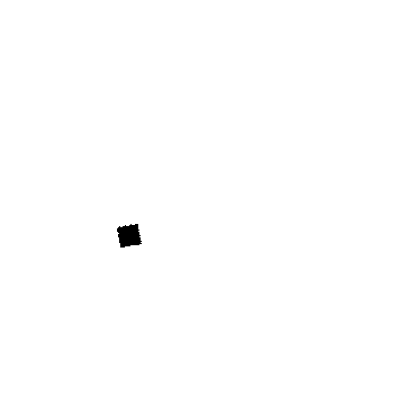

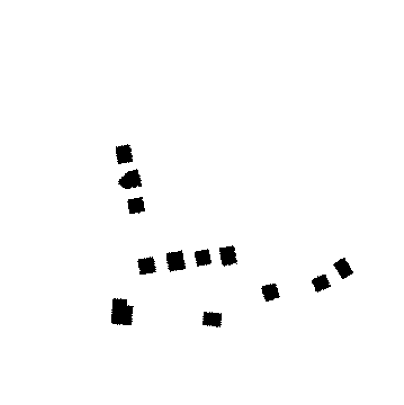

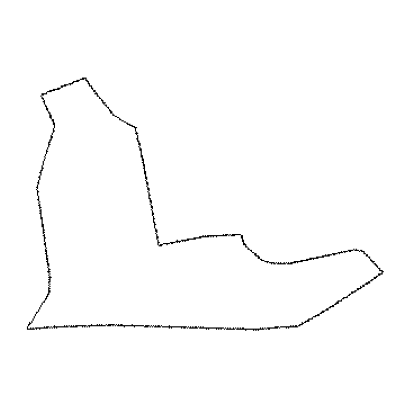

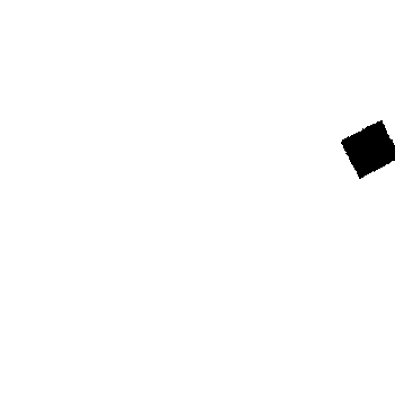

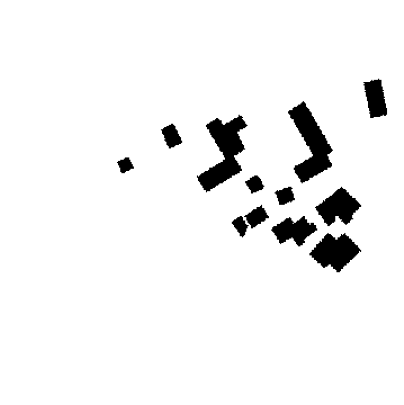

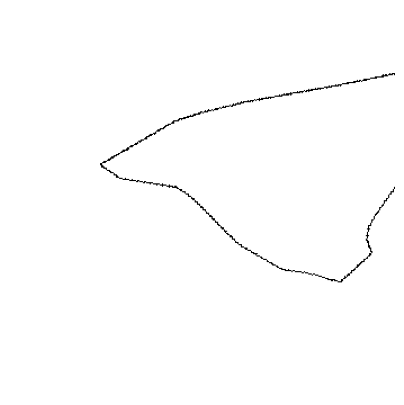

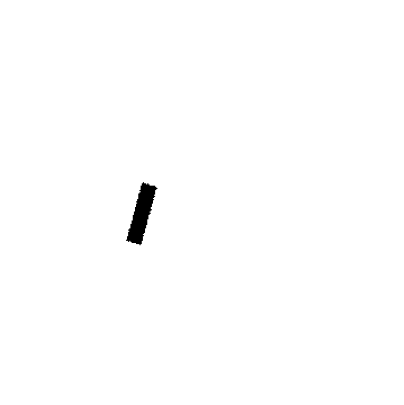

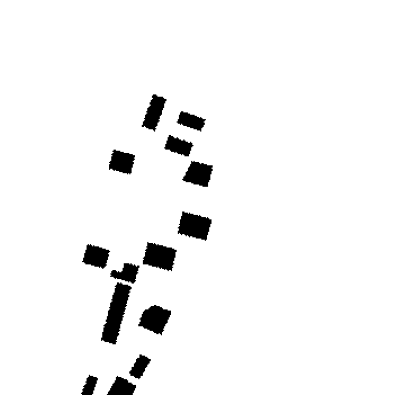

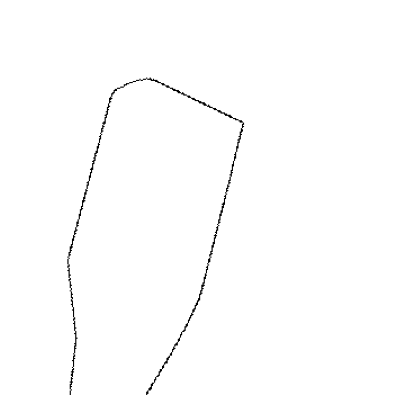

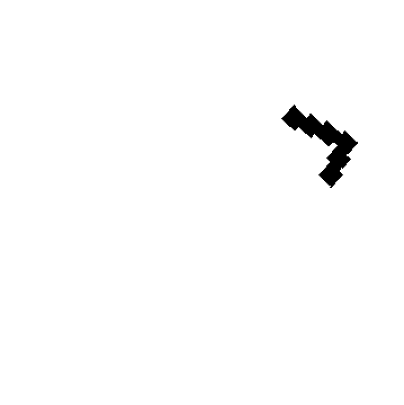

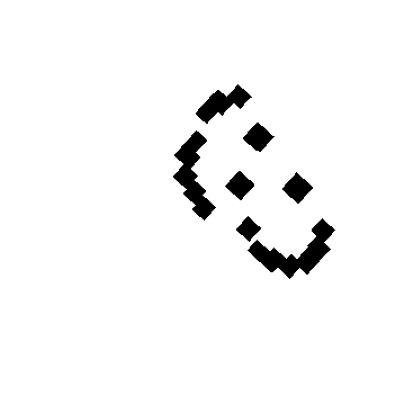

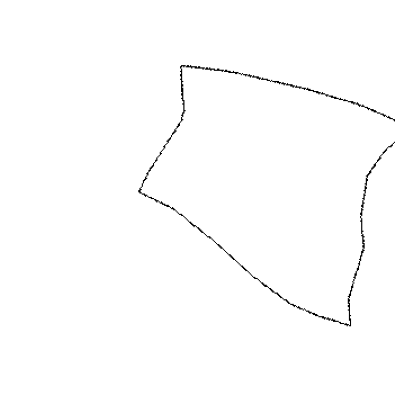

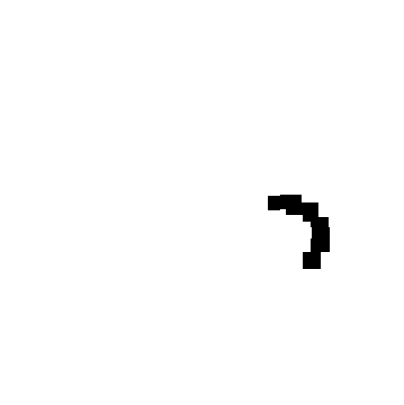

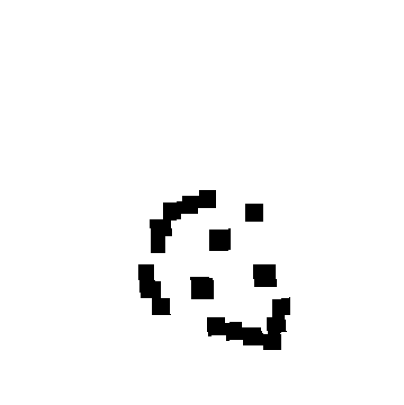

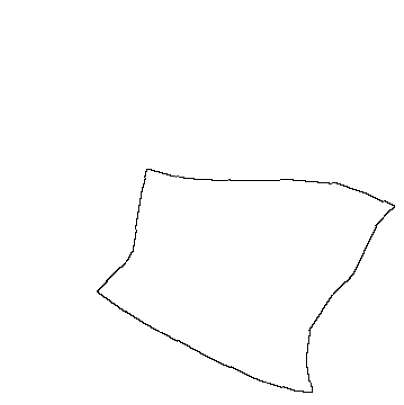

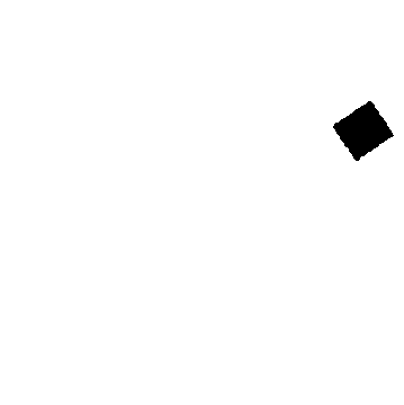

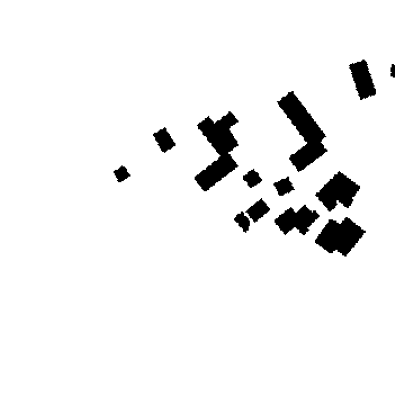

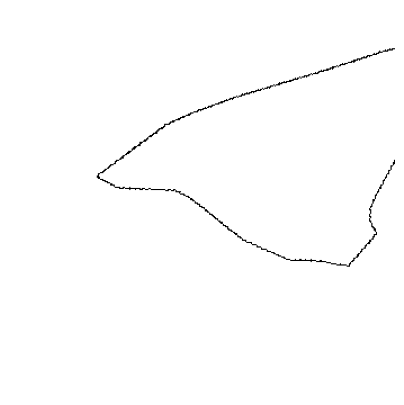

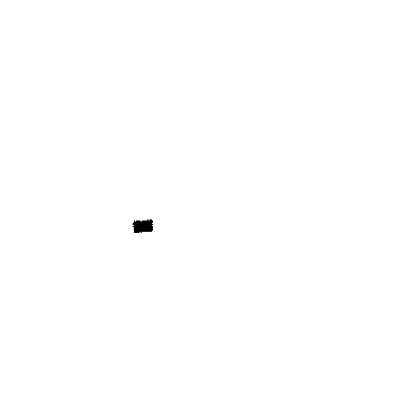

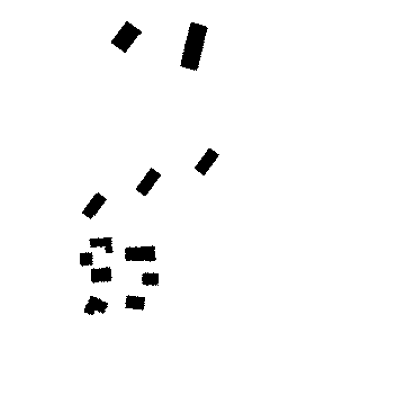

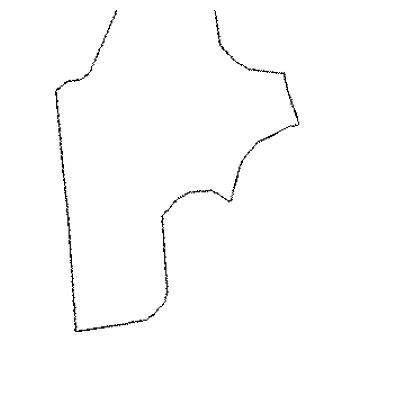

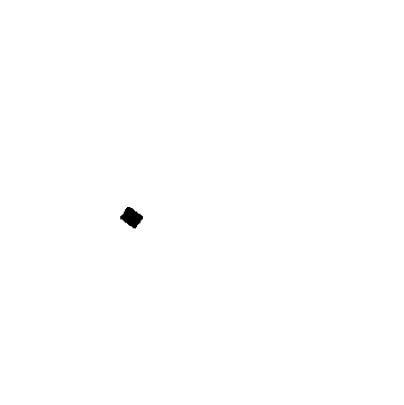

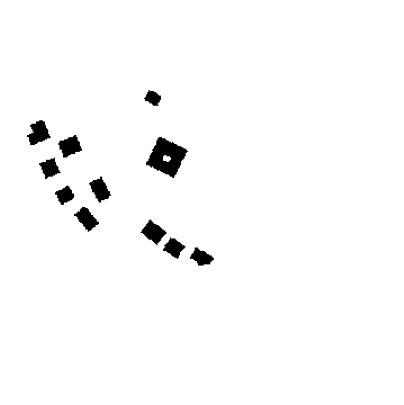

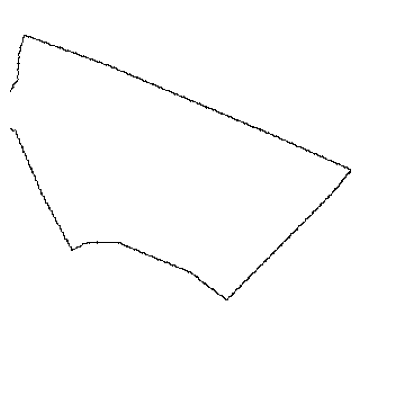

In [4]:
num_epochs = 10
batch_size = 4

data = "../training_samples.nosync/raster/raster_building_data.npz"

# composing various random transforms that should be applied to the data
transform = transforms.Compose(
    [transforms.RandomRotation(degrees=(0,360)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5)])

dataset = BuildingRasterDataset(data, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

total_samples = len(dataset)
n_iterations = math.ceil(total_samples/batch_size)

for epoch in range(num_epochs):
    for i, (uuid, block, genops) in enumerate(dataloader): 
        print(uuid[0])
        plot_raster(block.numpy()[0, 0])
        plot_raster(block.numpy()[0, 1])
        plot_raster(block.numpy()[0, 2])
        break
        # forward pass
        #outputs = model(block) # compute predictions, calls forward method under the hood
        #loss = criterion(outputs, genops) # calculate loss

        # backward pass
        #optimizer.zero_grad() # empty the gradients
        #loss.backward() # backpropagation
        #optimizer.step() # update the parameters
        
        if not (i + 1) % 5:
            print(f"epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}")

### Evaluation

In [ ]:
# prediction evaluations should not be part of the computational graph,
# gradients should not be tracked
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # reshape data and push to device
        outputs = model(images) # prediction on the trained model
        # .max() returns value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)